In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import math
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.neighbors import LocalOutlierFactor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import set_config
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from pandas.api.types import is_numeric_dtype
from itertools import product
from joblib import dump
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances
from yellowbrick.features import rank1d
from yellowbrick.features import rank2d
from yellowbrick.contrib.missing import MissingValuesBar
from yellowbrick.contrib.missing import MissingValuesDispersion
from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import residuals_plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
from scipy import stats
from pandas.api.types import is_numeric_dtype
from sklearn.base import BaseEstimator, is_classifier, is_regressor, TransformerMixin
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, recall_score 


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR  # <-- 確保引入 SVR
from sklearn.linear_model import BayesianRidge, Lasso
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.pipeline import make_pipeline


In [2]:
def plot_dataframe_structure(df):
    """
    Plot dataframe structure: It shows the different data types in the dataframe.

    Parameters
    ----------
    df: Pandas dataframe
    
    Returns
    -------
    Plotting
    """
    plt.figure()
    df.dtypes.value_counts().plot.pie(ylabel='')
    plt.title('Data types')
    plt.show()

def plot_categorical(df):
    """
    Plot the number of different values for each categorical feature in the dataframe.

    Parameters
    ----------
    df: Pandas dataframe
    
    Returns
    -------
    Plotting
    """
    plt.figure()
    df.nunique().plot.bar()
    plt.title('Number of different values')
    plt.show()
    
def duplicates(df):
    """
    Remove the duplicate rows from dataframe.

    Parameters
    ----------
    df: Pandas dataframe
    
    Returns
    -------
    df: Pandas dataframe without duplicate rows 
    """    
    duplicate_rows_df = df[df.duplicated()]
    if duplicate_rows_df.shape[0] > 0:
       print('Number of rows before removing:', df.count()[0])
       print('Number of duplicate rows:', duplicate_rows_df.shape[0])
       df = df.drop_duplicates()
       print('Number of rows after removing:', df.count()[0])
    else:
       print('No duplicate rows.')
    return df

def drop_na(df, threshold_NaN):
    """
    Remove the columns from dataframe containing NaN depending on threshold_NaN.

    Parameters
    ----------
    df: Pandas dataframe
    threshold_NaN: in [0, 1], from GUI
    
    Returns
    -------
    df: Pandas dataframe 
    drop_cols: list of dropped columns
    """    
    isna_stat = (df.isna().sum()/df.shape[0]).sort_values(ascending=True)
    drop_cols = []
    if isna_stat.max() > 0.0:
       drop_cols = np.array(isna_stat[isna_stat > threshold_NaN].index)
       print('Drop columns containing more than', threshold_NaN*100,'% of NaN:', drop_cols)
       df = df.drop(drop_cols, axis=1)
    else:
       print('No need to drop columns.')
    return df, drop_cols

def encoding(df, threshold_cat, target_col):
    """
    Encode the data.

    Parameters
    ----------
    df: Pandas dataframe
    threshold_cat: integer, if the number of different values of a given column is less than this limit, 
    this column is considered as categorical. 
    
    Returns
    -------
    df: Pandas dataframe 
    encoded_cols: Pandas dataframe of columns with their encoding and range
    """      
    encoded_cols = []
    drop_cols = np.array([])  # Initialize drop_cols as an empty array
    
    for c in df.columns:
        if df[c].dtypes == 'object' or df[c].dtypes.name == 'category': 
            encoded_cols.append([c, 'cat', df[c].dropna().unique().tolist()])
            print('Encoding object column:', c)
            df[c] = df[c].factorize()[0].astype(int)
        elif is_numeric_dtype(df[c]): 
            if df[c].unique().shape[0] > threshold_cat: 
                encoded_cols.append([c, 'num', [df[c].min(), df[c].max()]])
                print('Encoding numeric column:', c)
                df[c] = (df[c] - df[c].mean()) / df[c].std()
            else:
                print('Column ', c, ' is categorical.')
                encoded_cols.append([c, 'cat', df[c].dropna().unique().tolist()])
        else: 
            print('Unknown type ', df[c].dtypes, ' for column:', c) 
            df = df.drop(c, axis=1)
            drop_cols = np.unique(np.concatenate((drop_cols, [c])))  # Add column to drop_cols

    encoded_cols = pd.DataFrame(encoded_cols, columns=['column_name', 'column_type', 'column_range'])
    encoded_cols = encoded_cols.loc[encoded_cols['column_name'] != target_col]
    encoded_cols.to_csv('schema.csv', index=False)
    
    return df, encoded_cols

def imputation(df):
    """
    Impute NaN in the dataframe using IterativeImputer.

    Parameters
    ----------
    df: Pandas dataframe
    
    Returns
    -------
    df: Pandas dataframe 
    """        
    isna_stat = (df.isna().sum()/df.shape[0]).sort_values(ascending=True) 
    if isna_stat.max() > 0.0: 
       print('Imputing NaN using IterativeImputer') 
       df = pd.DataFrame(IterativeImputer(random_state=0).fit_transform(df), columns = df.columns)  
    else: 
       print('No need to impute data.')
    return df

def outliers(df, threshold_Z):
    """
    Remove the outliers from dataframe according to Z_score.

    Parameters
    ----------
    df: Pandas dataframe
    threshold_Z: number from GUI. 
    
    Returns
    -------
    df: Pandas dataframe. 
    """  
    Z_score = np.abs(stats.zscore(df)) 
    df_o_Z = df[(Z_score < threshold_Z).all(axis=1)]
    if df_o_Z.shape[0] != 0:
       print('Using Z_score, ', str(df.shape[0] - df_o_Z.shape[0]) ,' rows will be suppressed.') 
       df = df_o_Z
    else:
       print('Possible problem with outliers treatment, check threshold_Z') 
    return df

def correlated_columns(df, threshold_corr, target_col):
    """
    Display correlation matrix of features, and returns the list of the too correlated features
    according to threshold_corr.

    Parameters
    ----------
    df: Pandas dataframe
    threshold_corr: number from GUI
    target: target column
    Returns
    -------
    correlated_features: list of the features having a correlation greater than threshold_corr. 
    """  
    df = df.drop(target_col, axis=1)
    corr_matrix = df.corr() 
    correlated_features=[]
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold_corr: # we are interested in absolute coeff value
               colname = corr_matrix.columns[i]  # getting the name of column
               correlated_features.append(colname)
    correlated_features = list(dict.fromkeys(correlated_features))
    return correlated_features

def plot_sns_corr_class(df, target_col):
    """
    Plot correlation information for classification problem (if Seaborn option is checked).

    Parameters
    ----------
    df: Pandas dataframe
    target_col: name of the target column. 
    
    Returns
    -------
    Plotting. 
    """     
    g = sns.PairGrid(df, hue=target_col) 
    g.map_upper(sns.scatterplot) 
    g.map_lower(sns.kdeplot) 
    g.map_diag(sns.kdeplot, lw=3, legend=False) 
    g.add_legend() 
    g.fig.suptitle('Pairwise data relationships', y=1.01) 
    plt.show()
    
def plot_sns_corr_regre(df, target_col):
    """
    Plot correlation information for regression problem (if Seaborn option is checked).

    Parameters
    ----------
    df: Pandas dataframe
    target_col: name of the target column. 
    
    Returns
    -------
    Plotting. 
    """      
    g = sns.PairGrid(df)
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=3, legend=False)
    g.fig.suptitle('Pairwise data relationships', y=1.01)
    plt.show()
    
class Decorrelator(BaseEstimator, TransformerMixin):
    """
    Decorrelator is a class used to eliminate too correlated columns depending on a threshold during preprocessing.

    Parameters
    ----------
    threshold_corr
    """  
    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()  
        if not isinstance(X, pd.DataFrame):
           X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)
    
class ColumnsDropper(BaseEstimator, TransformerMixin):
    """
    ColumnsDropper is a class used to drop columns from a dataset.

    Parameters
    ----------
    cols : list of columns dropped by the transformer
    """  
    def __init__(self, cols):
        if not isinstance(cols, list):
            self.cols = [cols]
        else:
            self.cols = cols

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # there is nothing to fit
        return self

    def transform(self, X:pd.DataFrame):
        X = X.copy()
        return X[self.cols]    
    
def model_filtering(level_0, model_imp, nb_model, score_stack, threshold_score):
    """
    Suppress estimators from level 0 having a test score smaller than threshold_score (from score_stack), then 
    keep nb_model best estimators (according to model_imp).
    Parameters
    ----------
    level_0: list of estimators of level 0
    model_imp: sorted array of model importance
    nb_model : number of model to keep
    score_stack: accuracy of estimators on train and test sets in a tabular
    threshold_score : minimal score
    encoded_cols = pd.DataFrame(np.array(encoded_
    Returns
    -------
    list of filtered estimators of level 0
    """
    # it is not possible to keep more models than we initially have
    if nb_model > len(level_0):
       nb_model = len(level_0)
    
    # keep model names and test scores
    score_stack = np.delete(np.delete(score_stack, 1, axis =1), -1, axis = 0)
    # keep models having test score greater than threshold_score 
    score_stack = score_stack[score_stack[:,1] > threshold_score]
    
    # it is not possible to keep more models than we have filtered    
    if nb_model > len(score_stack):
       nb_model = len(score_stack)
    
    # keep models (in importance array) having test score greater than threshold_score
    model_imp = model_imp[np.in1d(model_imp[:, 0], score_stack)]
    model_imp_f = model_imp[np.argpartition(model_imp[:,1], -nb_model)[-nb_model:]].T[0]
    
    return list(filter(lambda x: x[0] in model_imp_f, level_0))

def feature_filtering(feature_importance, nb_feature):
    """
    Separate features in two lists, the first one contains the nb_feature most important features, 
    the second one contains the complement
    Parameters
    ----------
    feature_importance: array of features with their importance
    nb_feature: number of features we want to keep
    
    Returns
    -------
    best_feature: list of nb_feature most important features
    worst_feature: list of the worst important features
    """
    # check nb_feature
    if nb_feature > feature_importance.shape[0]:
       nb_feature = feature_importance.shape[0] 
    
    best_feature = feature_importance[np.argpartition(feature_importance[:,1], -nb_feature)[-nb_feature:]].T[0]
    worst_feature = list(set(feature_importance.T[0]) - set(best_feature))

    return best_feature, worst_feature

def split(X, y, random_state, test_size=0.33, threshold_entropy=0.7, undersampling=False, undersampler=None):
    """
    Split dataframe into train and test sets.
    If the Shannon entropy of the target dataset is less than 0.7, RepeatedStratifiedKFold is used

    Parameters
    ----------
    X: feature dataframe
    y: target dataframe
    
    Returns
    -------
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    """
    s_e = shannon_entropy(y)
    if s_e < threshold_entropy:
       if undersampling: 
          if undersampler == 'Random': 
             from imblearn.under_sampling import RandomUnderSampler
             us = RandomUnderSampler()
          elif undersampler == 'Centroids': 
             from imblearn.under_sampling import ClusterCentroids
             us = ClusterCentroids()
          elif undersampler == 'AllKNN': 
             from imblearn.under_sampling import AllKNN
             us = AllKNN()
          elif undersampler == 'TomekLinks': 
             from imblearn.under_sampling import TomekLinks
             us = TomekLinks()
          else:
             print("Unknown undersampler")       
          X, y = us.fit_resample(X, y)
          print("Shannon Entropy = {:.4}, split using undersampler {} and RepeatedStratifiedKFold".format(s_e, undersampler)) 
       else: 
          print("Shannon Entropy = {:.4}, split using RepeatedStratifiedKFold".format(s_e)) 
       skfold = RepeatedStratifiedKFold(n_splits=5, random_state = random_state)
       # enumerate the splits and summarize the distributions
       for ind_train, ind_test in skfold.split(X, y):
           X_train, X_test = X.iloc[ind_train], X.iloc[ind_test]
           y_train, y_test = y.iloc[ind_train], y.iloc[ind_test] 
    else:    
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=None,\
                                                           shuffle=True, random_state = random_state)
    return X_train, X_test, y_train, y_test
    
def downcast_dtypes(df):
    """
    Compress dataframe

    Parameters
    ----------
    df: Pandas dataframe
    
    Returns
    -------
    df: Pandas dataframe
    """      
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def shannon_entropy(y):
    """
    Compute Shannon entropy of a dataset

    Parameters
    ----------
    y: univariate Pandas dataframe
    
    Returns
    -------
    shannon entropy: float
    """     
    from collections import Counter
    from numpy import log
    
    n = len(y)
    classes = [(clas,float(count)) for clas,count in Counter(y).items()]
    k = len(classes)
    
    H = -sum([ (count/n) * log((count/n)) for clas,count in classes]) #shannon entropy
    return H/log(k)

def score_stacking_c(model, X_train, y_train, X_test, y_test):
    """
    Compute the score of the stacked classification estimator and of each level_0 estimator

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    plotting: accuracy of estimators on train and test sets
    res_stack: accuracy of estimators on train and test sets in a tabular
    """       
    nb_estimators = len(model.estimators_)
    res_stack = np.empty((nb_estimators + 1, 3), dtype='object')
    m_t_x_train = model.transform(X_train)
    for j in range(nb_estimators):
        res_stack [j, 0] = [*model.named_estimators_.keys()][j]
        if m_t_x_train.shape[1] == nb_estimators: 
           res_stack [j, 1] = accuracy_score(np.rint(m_t_x_train).T[j], y_train)
           res_stack [j, 2] = accuracy_score(np.rint(model.transform(X_test)).T[j], y_test)
        else: 
           res_stack [j, 1] = accuracy_score(m_t_x_train.reshape((X_train.shape[0],\
                                                                  nb_estimators,\
                                                                  y_train.unique().shape[0])).argmax(axis=2).T[j],\
                                             y_train)
           res_stack [j, 2] = accuracy_score(model.transform(X_test).reshape((X_test.shape[0],\
                                                                              nb_estimators,\
                                                                              y_test.unique().shape[0])).argmax(axis=2).T[j],\
                                             y_test)
    res_stack [len(model.estimators_) , 0] = 'Stack'
    res_stack [len(model.estimators_) , 1] = accuracy_score(model.predict(X_train), y_train)
    res_stack [len(model.estimators_) , 2] = accuracy_score(model.predict(X_test), y_test)  
    models = res_stack.T[0]
    score_train = res_stack.T[1]
    score_test = res_stack.T[2]
    plt.figure(figsize=(8,5))
    plt.scatter(models, score_train, label='Train')
    plt.scatter(models, score_test, label='Test')
    plt.title('Model scores: accuracy')
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.show()
    return res_stack

def score_stacking_r(model, X_train, y_train, X_test, y_test):
    """
    Compute the score of the stacked regression estimator and of each level_0 estimator

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    plotting: accuracy of estimators on train and test sets
    res_stack: accuracy of estimators on train and test sets in a tabular
    """        
    nb_estimators = len(model.estimators_)
    res_stack = np.empty((nb_estimators + 1, 3), dtype='object')
    m_t_x_train = model.transform(X_train)
    for j in range(nb_estimators):
        res_stack [j, 0] = [*model.named_estimators_.keys()][j]
        res_stack [j, 1] = r2_score(np.rint(m_t_x_train).T[j], y_train)
        res_stack [j, 2] = r2_score(np.rint(model.transform(X_test)).T[j], y_test)
    res_stack [len(model.estimators_) , 0] = 'Stack'
    res_stack [len(model.estimators_) , 1] = r2_score(model.predict(X_train), y_train)
    res_stack [len(model.estimators_) , 2] = r2_score(model.predict(X_test), y_test)  
    models = res_stack.T[0]
    score_train = res_stack.T[1]
    score_test = res_stack.T[2]
    plt.figure(figsize=(8,5))
    plt.scatter(models, score_train, label='Train')
    plt.scatter(models, score_test, label='Test')
    plt.title('Model scores: r2')
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.show()
    return res_stack

def score_stacking(model, X_train, y_train, X_test, y_test):
    """
    Compute the score of the stacked estimator and of each level_0 estimator

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    plotting: accuracy of estimators on train and test sets
    res_stack: accuracy of estimators on train and test sets in a tabular
    plotting: model importance according to performance
    mod_imp: model importance in a tabular
    """     
    if is_classifier(model):
       res_stack = score_stacking_c(model, X_train, y_train, X_test, y_test)
    else:
       res_stack = score_stacking_r(model, X_train, y_train, X_test, y_test) 
    nb_estimators = len(model.estimators_)
    res_level_0 = res_stack[0:nb_estimators]
    mod_imp = np.delete(res_level_0[res_level_0[:, 2].argsort()], 1, axis=1)
    mod_imp.T[1] = mod_imp.T[1] / np.sum(mod_imp.T[1])
    fig, ax = plt.subplots()
    ax.barh(mod_imp.T[0], mod_imp.T[1])
    ax.set_title("Model Importance according to performance")
    fig.tight_layout()
    plt.show()
    return res_stack, mod_imp

def find_coeff(model):
    """
    Searches the wrapped model for the feature importances parameter.
    """
    for attr in ("feature_importances_", "coef_"):
        try:
           return getattr(model, attr)
        except AttributeError:
           continue

        raise YellowbrickTypeError(
           "could not find feature importances param on {}".format(
                model.__class__.__name__
           )
        )
        
def model_importance_c(model, level_1_model):
    """
    Compute the model importance depending on final estimator coefficients for classification

    Parameters
    ----------
    model: estimator obtained after fitting

    Returns
    -------
    mod_imp: sorted array of model importance 
    """        
    level_0 = np.array(list(model.named_estimators_.keys()))
    n_classes = model.classes_.shape[0]
    n_models = len(model.estimators_)
    model_coeff = find_coeff(model.final_estimator_)
    
    if level_1_model == 'tree':
       if len(model_coeff) == n_models:
          coeff = model_coeff.reshape(n_models)  
       else:
          coeff = sum(model_coeff.reshape(n_classes,n_models))
            
    if level_1_model == 'regression':
       if len(model_coeff[0]) == n_models:
          coeff = model_coeff.reshape(n_models)  
       else:
          coeff = sum(model_coeff.reshape(n_classes,n_models,n_classes)[i].T[i] for i in range(n_classes))
            
    model_importance = np.empty((len(level_0), 2), dtype='object')
    for ind in range(len(level_0)):
        model_importance[ind, 0] = level_0[ind]
        model_importance[ind, 1] = np.abs(coeff[ind])
    return model_importance[model_importance[:, 1].argsort()]

def model_importance_r(model, level_1_model):
    """
    Compute the model importance depending on final estimator coefficients for regression

    Parameters
    ----------
    model: estimator obtained after fitting
    
    Returns
    -------
    mod_imp: sorted array of model importance 
    """         
    level_0 = np.array(list(model.named_estimators_.keys()))
    coeff = find_coeff(model.final_estimator_)
    model_importance = np.empty((len(level_0), 2), dtype='object')
    for ind in range(len(level_0)):
        model_importance[ind, 0] = level_0[ind]
        model_importance[ind, 1] = np.abs(coeff[ind])
    return model_importance[model_importance[:, 1].argsort()]

def plot_model_importance(model, level_1_model):
    """
    Compute the model importance depending on final estimator coefficients

    Parameters
    ----------
    model: estimator obtained after fitting
    
    Returns
    -------
    plotting: model importance according to aggragator coefficients
    mod_imp: sorted array of model importance 
    """      
    if is_classifier(model):
       mod_imp = model_importance_c(model, level_1_model)
    else:
       mod_imp = model_importance_r(model, level_1_model)
    mod_imp.T[1] = mod_imp.T[1] / np.sum(mod_imp.T[1])
    fig, ax = plt.subplots()
    ax.barh(mod_imp.T[0], mod_imp.T[1])
    ax.set_title("Model Importance according to aggragator coefficients")
    fig.tight_layout()
    plt.show()
    return mod_imp

def plot_perm_importance(model, X, y, CPU):
    """
    Compute the feature permutation importance

    Parameters
    ----------
    model: estimator obtained after fitting
    X: feature dataframe
    y: target dataframe
    CPU: boolean for CPU training
    
    Returns
    -------
    plotting: feature permutation importance
    perm_imp: sorted array of feature permutation importance
    """       
    if is_classifier(model):
       scoring = 'accuracy'
    else:
       scoring = 'r2'  
    if CPU==True:
       result = permutation_importance(model, X, y, scoring=scoring, n_repeats=10, n_jobs=-1)
    else:
       result = permutation_importance(model, X, y, scoring=scoring, n_repeats=10)
    sorted_idx = result.importances_mean.argsort()
    perm_imp = np.array([X.columns[sorted_idx], result.importances[sorted_idx].mean(axis=1).T]).T
    perm_imp.T[1] = perm_imp.T[1] / np.sum(perm_imp.T[1])
    fig, ax = plt.subplots()
    ax.barh(perm_imp.T[0], perm_imp.T[1])
    ax.set_title("Permutation Importance")
    fig.tight_layout()
    plt.show()
    return perm_imp

def plot_partial_dependence_c(model, X, features, CPU):
    """
    Plot partial dependence of features for a given classification estimator and a given dataset

    Parameters
    ----------
    model: estimator obtained after fitting
    X: feature dataframe
    features: list of features
    CPU: boolean for CPU training
    
    Returns
    -------
    plotting: partial dependence of input features
    """      
    target = model.classes_
    for ind in range(len(target)):
        fig, ax = plt.subplots(figsize=(16, 8))
        if CPU==True:
           display = PartialDependenceDisplay.from_estimator(
                     estimator = model,
                     X = X,
                     features = features,
                     target = target[ind],
                     n_cols = 2,
                     kind = "both",
                     subsample=50,
                     n_jobs = -1,
                     grid_resolution = 20,
                     ice_lines_kw = {"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                     pd_line_kw = {"color": "tab:orange", "linestyle": "--"},
                     ax = ax,
                     )
        else:
           display = PartialDependenceDisplay.from_estimator(
                     estimator = model,
                     X = X,
                     features = features,
                     target = target[ind],
                     n_cols = 2,
                     kind = "both",
                     subsample=50,
                     grid_resolution = 20,
                     ice_lines_kw = {"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                     pd_line_kw = {"color": "tab:orange", "linestyle": "--"},
                     ax = ax,
                     )
        display.figure_.suptitle("Partial dependence for class " + str(target[ind]))
        display.figure_.subplots_adjust(hspace=0.3)
        plt.show()
    
def plot_partial_dependence_r(model, X, features, CPU):
    """
    Plot partial dependence of features for a given regression estimator and a given dataset

    Parameters
    ----------
    model: estimator obtained after fitting
    X: feature dataframe
    features: list of features
    CPU: boolean for CPU training
    
    Returns
    -------
    plotting: partial dependence of input features
    """      
    fig, ax = plt.subplots(figsize=(16, 8))
    if CPU==True:
       display = PartialDependenceDisplay.from_estimator(
                 estimator = model,
                 X = X,
                 features = features,
                 n_cols = 2,
                 kind="both",
                 subsample=50,
                 n_jobs=-1,
                 grid_resolution=20,
                 ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                 pd_line_kw={"color": "tab:orange", "linestyle": "--"},
                 ax = ax,
                 )
    else:
       display = PartialDependenceDisplay.from_estimator(
                 estimator = model,
                 X = X,
                 features = features,
                 n_cols = 2,
                 kind="both",
                 subsample=50,
                 grid_resolution=20,
                 ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                 pd_line_kw={"color": "tab:orange", "linestyle": "--"},
                 ax = ax,
                 )
    display.figure_.suptitle("Partial dependence")
    display.figure_.subplots_adjust(hspace=0.3)
    plt.show() 

def plot_partial_dependence(model, X, features, CPU):
    """
    Plot partial dependence of features for a given estimator and a given dataset

    Parameters
    ----------
    model: estimator obtained after fitting
    X: feature dataframe
    features: list of features, if features = [], partial dependences will be plot for all numeric features
    CPU: boolean for CPU training
    
    Returns
    -------
    plotting: partial dependence of input features
    """    
    # if input list of features is empty, we use the list of numeric features
    if features == []:
       features = X.select_dtypes([np.number]).columns.tolist() 
    else:
    #  we keep only numeric features    
       features = np.intersect1d(features, X.select_dtypes([np.number]).columns.tolist()).tolist() 
        
    if features == []:
       return "No numeric feature"
    else:
       if is_classifier(model):
          plot_partial_dependence_c(model, X, features, CPU)
       else:
          plot_partial_dependence_r(model, X, features, CPU)

def plot_history(history):
    """
    Plot learning curves of Keras neural network

    Parameters
    ----------
    history: history of Keras neural network
    
    Returns
    -------
    plotting: learning curves of Keras neural network
    """     
    pd.DataFrame(history.history).plot(figsize=(12, 9))
    plt.title("Learning Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
def K_confusion_matrix(model, X_train, y_train, X_test, y_test):
    """
    Plot confusion matrix of a classification estimator on train and test sets

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    plotting: confusion matrix on train and test sets
    """     
    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(X_train)
    if len(y_pred.shape)>1:
       y_pred = np.around(y_pred).astype(int)
       y_pred = np.argmax(y_pred, axis=1)
       y_train = y_train.idxmax(axis=1)
    cm = confusion_matrix(y_train, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion matrix on train set')
    plt.show()
    y_pred = model.predict(X_test)
    if len(y_pred.shape)>1:
       y_pred = np.around(y_pred).astype(int)
       y_pred = np.argmax(y_pred, axis=1)
       y_test = y_test.idxmax(axis=1)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion matrix on test set')
    plt.show()
    
def K_classification_report(model, X_train, y_train, X_test, y_test):
    """
    Plot classification report of a classification estimator on train and test sets

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    plotting: classification report on train and test sets
    """        
    y_pred = model.predict(X_train)
    if len(y_pred.shape)>1:
       y_pred = np.around(y_pred).astype(int)
       y_pred = np.argmax(y_pred, axis=1)
       y_train = y_train.idxmax(axis=1)
    cr=classification_report(y_train, y_pred, output_dict=True)
    display(pd.DataFrame(cr).transpose().style.set_caption("Classification report on train set"))
    y_pred = model.predict(X_test)
    if len(y_pred.shape)>1:
       y_pred = np.around(y_pred).astype(int)
       y_pred = np.argmax(y_pred, axis=1)
       y_test = y_test.idxmax(axis=1)
    cr=classification_report(y_test, y_pred, output_dict=True)
    display(pd.DataFrame(cr).transpose().style.set_caption("Classification report on test set"))
    
def K_r2(model, X_train, y_train, X_test, y_test):
    """
    Compute R^2 of a regression estimator on train and test sets.

    Parameters
    ----------
    model: estimator obtained after fitting
    X_train: train feature dataframe 
    X_test: test feature dataframe
    y_train: train target dataframe
    y_test: test target dataframe
    
    Returns
    -------
    array: scores on train and test sets
    """         
    y_pred_train = model.predict(X_train)    
    y_pred_test = model.predict(X_test)
    dr2={'train': [r2_score(y_train, y_pred_train)],\
         'test': [r2_score(y_test, y_pred_test)]}
    display(pd.DataFrame(data=dr2).style.hide_index())
     
def fastapi_server(model, model_name, X, y):
    """
    Generate the fastAPI server file, and save it in the current folder.

    Parameters
    ----------
    model: estimator obtained after fitting
    model_name : name of the saved model
    X: feature dataframe 
    y: target dataframe
    
    """   
    string = ""
    string = string  + "from fastapi import FastAPI\n"
    string = string  + "from loguru import logger\n"
    string = string  + "from joblib import load\n"
    string = string  + "import pandas as pd\n"
    string = string  + "import numpy as np\n"
    string = string  + "import uvicorn\n"
    string = string  + "import ast\n"
    string = string  + "import time\n"
    string = string  + "from sklearn.base import is_classifier\n"
    string = string  + "from pydantic import BaseModel\n"
    string = string  + "\n"
    string = string  + "# Creating FastAPI instance\n"
    string = string  + "app = FastAPI()\n"
    string = string  + "\n"
    string = string  + "# Creating class to define the request body\n"
    string = string  + "# and the type hints of each attribute\n"

    string = string  + "\n"
    string = string  + "class request_body(BaseModel):\n"
    for ind in range(X.dtypes.shape[0]):
        if str(X.dtypes[ind])[0:5]=='float':
           string = string + '      ' + X.columns[ind] + ': float\n'
        if str(X.dtypes[ind])[0:3]=='int':
           string = string + '      ' + X.columns[ind] + ': int\n'
        if str(X.dtypes[ind])[0:4]=='uint':
           string = string + '      ' + X.columns[ind] + ': int\n'
        if str(X.dtypes[ind])[0:6]=='object':
           string = string + '      ' + X.columns[ind] + ': str\n'
        if str(X.dtypes[ind])[0:4]=='bool':
           string = string + '      ' + X.columns[ind] + ': bool\n'

    string = string  + "\n"
    string = string  + "# read dataframe schema\n"
    string = string  + "schema = pd.read_csv('schema.csv')" 
    string = string  + "\n"        
    modulename = 'keras'
    keras_bool = False
    if modulename in sys.modules:
       keras_bool = True 
       from EZS_deps.EZS_tech_func import keras_nn
       if is_classifier(model):
          string = string  + keras_nn('classification')
       else:
          string = string  + keras_nn('regression')
        
    string = string  + "\n"        
    string = string  + "model = load('" + model_name + "')\n"

    string = string  + "\n"
    if is_classifier(model):
       string = string  + "classes = " + str(y.unique().tolist()) + "\n"
    
    string = string  + "\n"
    string = string  + "@app.get('/ping')\n"
    string = string  + "def pong():\n"
    string = string  + "    return {'ping': 'pong!'}\n"
    
    string = string  + "\n"
    string = string  + "@app.post('/predict')\n"
    string = string  + "def predict(data : request_body):\n"
    string = string  + "\n"
    string = string  + "    elaps_start_time = time.time()\n"
    string = string  + "    cpu_start_time = time.process_time()\n"
    string = string  + "\n"
    string = string  + "    # Making the data in a form suitable for prediction\n"
    string = string  + "    test_data = [[\n"
    for ind in range(X.columns.shape[0]):
        string = string  + "              data." + X.columns[ind] + ',\n'
    string = string  + "    ]]\n"
    
    string = string  + "\n"
    
    string = string  + "    # Check input data\n"
    string = string  + "    data_err = []\n"
    string = string  + "    for ind in range(len(test_data[0])):\n"
    string = string  + "        if schema.iloc[ind][1] == 'num':\n"
    string = string  + "           interval = ast.literal_eval(schema.iloc[ind][2])\n"
    string = string  + "           if (test_data[0][ind] < interval[0]) | (test_data[0][ind] > interval[1]):\n"
    string = string  + "              data_err.append(schema.iloc[ind][0])\n"
    string = string  + "        if schema.iloc[ind][1] == 'cat':\n"
    string = string  + "           domain = ast.literal_eval(schema.iloc[ind][2])\n"
    string = string  + "           if not(np.isin(test_data[0][ind], domain)):\n"
    string = string  + "              data_err.append(schema.iloc[ind][0])\n"
    string = string  + "\n"

                
    if is_classifier(model):
       string = string  + "    # Predicting the Class\n"
       string = string  + "    result = model.predict(pd.DataFrame(test_data,\n"
       string = string  + "                                        columns=[\n"
       for ind in range(X.columns.shape[0]):
           string = string  + "                                                  '" + X.columns[ind] + "',\n"
       string = string  + "                          ]))[0].item()\n"
       string = string  + "\n"

       string = string  + "    elaps_end_time = time.time()\n"
       string = string  + "    cpu_end_time = time.process_time()\n"
       string = string  + "    elapsed_time = np.round((elaps_end_time - elaps_start_time) * 1000)\n"
       string = string  + "    elaps = str(elapsed_time) + 'ms'\n"
       string = string  + "    cpu_time = np.round((cpu_end_time - cpu_start_time) * 1000)\n"
       string = string  + "    cpu = str(cpu_time) + 'ms'\n"       
       string = string  + "\n"
       string = string  + "    # Return the Result\n"
       string = string  + "    return { 'class' : classes[result], 'error' : data_err, 'elapsed time' : elaps, 'cpu time' : cpu}\n"
    else: 
       string = string  + "    # Predicting the regression value\n"
       if keras_bool: 
          string = string  + "    result = model.predict(pd.DataFrame(np.array([test_data[0],]*2),\n"
       else:
          string = string  + "    result = model.predict(pd.DataFrame(test_data,\n"        
       string = string  + "                                        columns=[\n"
       for ind in range(X.columns.shape[0]):
           string = string  + "                                                 '" + X.columns[ind] + "',\n"
       string = string  + "                          ]))[0].item()\n"
       string = string  + "\n"
       string = string  + "    elaps_end_time = time.time()\n"
       string = string  + "    cpu_end_time = time.process_time()\n"
       string = string  + "    elapsed_time = np.round((elaps_end_time - elaps_start_time) * 1000)\n"
       string = string  + "    elaps = str(elapsed_time) + 'ms'\n"
       string = string  + "    cpu_time = np.round((cpu_end_time - cpu_start_time) * 1000)\n"
       string = string  + "    cpu = str(cpu_time) + 'ms'\n"
       string = string  + "\n"
       string = string  + "    # Return the Result\n"
       string = string  + "    return { 'regression_value' : result, 'error' : data_err, 'elapsed time' : elaps, 'cpu time' : cpu}\n"
    
    string = string  + "\n"
    string = string  + "from pyngrok import ngrok\n"
    string = string  + "ngrok_tunnel = ngrok.connect(8000)\n"
    string = string  + "ngrok_tunnel\n"

    string = string  + "\n"
    string = string  + "import nest_asyncio\n"
    string = string  + "\n"
    string = string  + "nest_asyncio.apply()\n"
    string = string  + "uvicorn.run(app, port=8000)\n"

    file_server = open("server.py", "w") 
    file_server.write(string)
    file_server.close()  

def store_data(name, level_1_model, score_stack_0, score_stack_1, score_stack_2, 
           model_imp_0, model_imp_1, model_imp_2, 
           feature_importance_0, feature_importance_1, feature_importance_2):
    import sqlite3
    conn = sqlite3.connect('/home/philippe/development/python/EZStacking/EZS_deps/EZS_store.db')
    cursor = conn.cursor()

    search_problem = cursor.execute("SELECT name FROM problem WHERE name = ?", (name,))
    problem_name = search_problem.fetchone()
    if problem_name == None:
       cursor.execute("INSERT INTO problem (name, path , type, target) VALUES(?, ?, ?, ?)", (name, path, problem_type, target_col))

    search_version = cursor.execute("SELECT MAX(version) FROM solution WHERE name = ?", (name,))
    row = search_version.fetchone()
    if row == (None,):
       version = 1
    else:
       version = row[0] + 1

    cursor.execute("INSERT INTO solution (name, version, correlation, nb_model, nb_feature, score, test_size) VALUES(?, ?, ?, ?, ?, ?, ?)", \
                    (name, version, threshold_corr, threshold_model, threshold_feature, threshold_score, test_size));

    schema = pd.read_csv('schema.csv')
    for ind in range(len(user_drop_cols)):
        cursor.execute("INSERT INTO eda (name, version, feature, type, range, drop_user, drop_correlation, target)  VALUES(?, ?, ?, ?, ?, ?, ?, ?)", \
                        (name, version, user_drop_cols[ind], None, None, 1, 0, 0));
    for ind in range(schema.shape[0]):
        if schema['column_name'][ind] in correlated_features:
           drop_correlation = True
        else:
           drop_correlation = False

        cursor.execute("INSERT INTO eda (name, version, feature, type, range, drop_user, drop_correlation, target)  VALUES(?, ?, ?, ?, ?, ?, ?, ?)", \
                        (name, version, schema['column_name'][ind], schema['column_type'][ind], schema['column_range'][ind], 0, drop_correlation, 0));

    cursor.execute("INSERT INTO eda (name, version, feature, type, range, drop_user, drop_correlation, target)  VALUES(?, ?, ?, ?, ?, ?, ?, ?)", \
                        (name, version, target_col, None, None, 0, 0, 1));

    for ind in range(3):
        cursor.execute("INSERT INTO model (name, version, step, L1_model) VALUES (?, ?, ?, ?)", \
                        (name, version, ind+1, level_1_model));

        score_stack = locals()["_".join(['score_stack', str(ind)])]
        for ind2 in range(score_stack.shape[0]):
            cursor.execute("INSERT INTO model_score (name, version, step, model, train_score, test_score) VALUES(?, ?, ?, ?, ?, ?)", \
                            (name, version, ind+1, score_stack[ind2,0], score_stack[ind2,1], score_stack[ind2,2]));

        model_imp = locals()["_".join(['model_imp', str(ind)])]
        for ind2 in range(model_imp.shape[0]):
            cursor.execute("INSERT INTO model_importance (name, version, step, model, importance) VALUES(?, ?, ?, ?, ?)", \
                            (name, version, ind+1, model_imp[ind2,0], model_imp[ind2,1]));

        feature_importance = locals()["_".join(['feature_importance', str(ind)])]
        for ind2 in range(feature_importance.shape[0]):
            cursor.execute("INSERT INTO feature_importance (name, version, step, feature, importance) VALUES(?, ?, ?, ?, ?)", \
                            (name, version, ind+1, feature_importance[ind2,0], feature_importance[ind2,1]));

    # cursor.execute("DELETE FROM problem WHERE name = ?", (name,))

    conn.commit()
    conn.close()

import pandas as pd
from datetime import datetime, timedelta
from math import sin, trunc

# Constants for the provided location
longitude = 121.56387313547269

# Function to calculate days since Jan 1, 2000
def epoch_2k_day(query_date):
    epoch_year = datetime(2000, 1, 1, 12, 0, 0)
    return (query_date - epoch_year).days + (query_date - epoch_year).seconds / 86400.0

# Equation of Time (EOT) function
def equation_of_time(days):
    cycle = round(days / 365.25)
    theta = 0.0172024 * (days - 365.25 * cycle)
    amp1 = 7.36303 - cycle * 0.00009
    amp2 = 9.92465 - cycle * 0.00014
    rho1 = 3.07892 - cycle * 0.00019
    rho2 = -1.38995 + cycle * 0.00013
    eot1 = amp1 * sin(1 * (theta + rho1))
    eot2 = amp2 * sin(2 * (theta + rho2))
    eot3 = 0.31730 * sin(3 * (theta - 0.94686))
    eot4 = 0.21922 * sin(4 * (theta - 0.60716))
    return 0.00526 + eot1 + eot2 + eot3 + eot4  # minutes

# Function to calculate solar noon with precision up to seconds
def solar_noon_precise(longitude_offset_minutes, timezone_offset=8):
    noon_minutes = 12 * 60
    total_minutes = noon_minutes + longitude_offset_minutes + (timezone_offset * 60)
    hours = trunc(total_minutes / 60)
    minutes = trunc(total_minutes - (hours * 60))
    seconds = round((total_minutes - (hours * 60) - minutes) * 60)
    return f'{int(hours):02}:{int(minutes):02}:{int(seconds):02}'

# Function to calculate solar noon offset
def longitude_offset(eot, longitude):
    return -1 * (eot + (4 * longitude))

def feature_engineering(df):
    """
    Perform feature engineering on the dataset, including time-based features,
    rolling statistics, and interaction features.
    
    Args:
    df (pd.DataFrame): Input dataset containing weather and power data.

    Returns:
    pd.DataFrame: DataFrame with newly created features.
    """
    # Convert DateTime to datetime format
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    
    # Extract time-based features
    df['month'] = df['DateTime'].dt.month
    df['day'] = df['DateTime'].dt.day
    df['hour'] = df['DateTime'].dt.hour
    df['minute'] = df['DateTime'].dt.minute
    
    # Create cyclic features (sin and cos) for time of day
    df['day_seconds'] = df['hour'] * 3600 + df['minute'] * 60 + df['DateTime'].dt.second
    df['day_cos'] = np.cos(2 * np.pi * df['day_seconds'] / (24 * 3600))
    df['day_sin'] = np.sin(2 * np.pi * df['day_seconds'] / (24 * 3600))
    #df['min_sin'] = np.sin(2 * np.pi * df['day_seconds'] / (24 * 60))
    #df['min_cos'] = np.cos(2 * np.pi * df['day_seconds'] / (24 * 60))


    df['day_in_week'] = df['DateTime'].dt.dayofweek

    # 新增 is_weekend 欄位
    df['is_weekend'] = df['day_in_week'].isin([5, 6])
    # Interaction features
    #df['sunlight_temp_interaction'] = df['Sunlight(Lux)'] * df['Temperature(°C)']
    

    # Handle missing values by filling with mean
    #df.fillna(df.mean(), inplace=True)
    
    return df

In [3]:
df = pd.read_csv('L1_Generated.csv')
df = df.dropna(subset=['Power(mW)_x'])


In [4]:
target_col = 'Power(mW)_x'
threshold_NaN = 0.5
threshold_cat = 5
threshold_Z = 3.0
test_size = 0.33
threshold_entropy = 0.75
undersampling = False
undersampler = 'Random'
threshold_corr = 0.75
threshold_model = 6
threshold_score = 0.01
threshold_feature = 50
CPU = False
level_1_model = 'regression'    
#user_drop_cols = ['EWMA_Sunlight6', 'EWMA_Sunlight3','EWMA_Sunlight4' , 'Rolling_Mean_Sunlight', 'Power(mW)_y']
user_drop_cols = []

In [5]:
df = df.drop(user_drop_cols, axis=1)
df_copy = df.copy()
df.shape

(747267, 21)

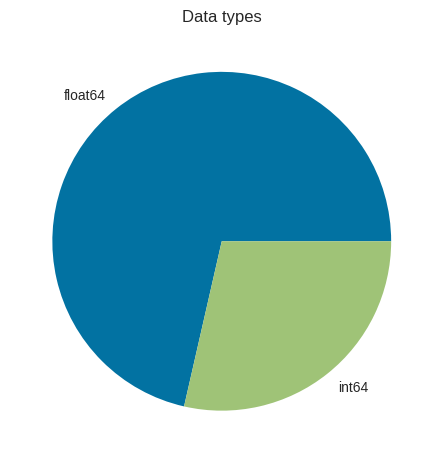

In [6]:
plot_dataframe_structure(df)

In [7]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Power(mW)_x,747267.0,367.792791,541.770146,0.000000,8.953000,55.132000,570.503000,2272.618000
LocationCode_x,747267.0,9.252861,4.926276,1.000000,5.000000,9.000000,13.000000,17.000000
WindSpeed(m/s),747267.0,0.380572,0.769593,0.000000,0.000000,0.000000,0.366000,7.262000
Pressure(hpa),747267.0,1008.824543,11.218037,958.511000,1004.305000,1007.829000,1012.623000,2605.746000
Temperature(°C),747267.0,33.121929,9.089311,12.290000,26.389000,32.619000,39.336000,59.870000
Humidity(%),747267.0,61.398833,24.643022,11.665000,40.947000,59.762000,81.803000,106.666667
Sunlight(Lux),747267.0,29773.326065,31910.730056,24.404286,6087.415000,15078.834000,45346.698000,117758.200000
Power(mW)_y,747267.0,368.931110,542.973573,0.000000,8.926000,55.130000,574.904000,2272.618000
Sunlight(Lux)_Normalized,747267.0,0.251856,0.272175,0.000000,0.049714,0.126061,0.384543,1.000000
Sunlight_Lux_Mean,747267.0,29452.264265,10539.533377,8070.159737,20325.458811,28141.547875,34810.881585,54818.022661


In [8]:
duplicates(df)

No duplicate rows.


,Power(mW)_x,LocationCode_x,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)_y,Sunlight(Lux)_Normalized,Sunlight_Lux_Mean,...,LocationCode_y,month,day,hour,minute,day_seconds,day_cos,day_sin,TimeDifference_hours,Power(mW)_x_predicted
0,190.090,8,0.000000,1008.520000,29.20000,60.455000,11244.583000,37.089000,0.092995,17175.118302,...,12.0,3,31,11,0,39600,-0.965926,0.258819,0.964722,119.149550
1,5.589,9,0.000000,1006.373750,33.98625,72.592500,5426.458750,6.448750,0.044938,18428.782670,...,8.0,6,27,16,40,60000,-0.342020,-0.939693,4.719444,2.887571
2,29.433,5,0.243000,1004.207000,27.95100,98.410000,11451.332000,26.527000,0.092697,43437.522097,...,4.0,5,23,14,0,50400,-0.866025,-0.500000,2.158333,31.275259
3,48.380,10,1.176000,1009.531000,30.52500,48.552000,29703.166000,193.670000,0.248472,43437.522097,...,4.0,5,14,9,50,35400,-0.843391,0.537300,2.001667,43.172646
4,1963.844,8,0.000000,1017.151000,43.19000,42.930000,62786.941000,1553.584000,0.532649,27041.475178,...,17.0,2,20,11,50,42600,-0.999048,0.043619,0.292500,1960.754600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747262,11.833,12,1.071000,1012.506000,42.53800,30.508000,81911.446000,1693.429000,0.774919,8070.159737,...,11.0,3,25,10,20,37200,-0.906308,0.422618,1.661389,15.111052
747263,15.089,9,0.636667,1016.714444,22.78000,72.006667,24577.963333,144.733333,0.204000,32784.382375,...,14.0,2,23,14,0,50400,-0.866025,-0.500000,1.880000,29.826962
747264,140.248,8,1.138000,1006.325000,33.56000,42.576000,38654.954000,425.728000,0.326606,34810.881585,...,2.0,4,1,14,40,52800,-0.766044,-0.642788,2.706667,123.538330
747265,1538.018,6,2.394000,1004.660000,41.97800,34.864000,104405.977000,1538.018000,0.916979,41157.889138,...,6.0,5,31,10,20,37200,-0.906308,0.422618,1.523889,1544.629200


In [9]:
df, drop_cols = drop_na(df, threshold_NaN)

No need to drop columns.


In [10]:
dropped_cols = np.unique(np.concatenate((drop_cols, user_drop_cols)))

In [11]:
display(dropped_cols)

array([], dtype=float64)

In [12]:
df, encoded_cols = encoding(df, threshold_cat, target_col)

Encoding numeric column: Power(mW)_x
Encoding numeric column: LocationCode_x
Encoding numeric column: WindSpeed(m/s)
Encoding numeric column: Pressure(hpa)
Encoding numeric column: Temperature(°C)
Encoding numeric column: Humidity(%)
Encoding numeric column: Sunlight(Lux)
Encoding numeric column: Power(mW)_y
Encoding numeric column: Sunlight(Lux)_Normalized
Encoding numeric column: Sunlight_Lux_Mean
Encoding numeric column: Sunlight_Lux_StdDev
Encoding numeric column: LocationCode_y
Encoding numeric column: month
Encoding numeric column: day
Encoding numeric column: hour
Encoding numeric column: minute
Encoding numeric column: day_seconds
Encoding numeric column: day_cos
Encoding numeric column: day_sin
Encoding numeric column: TimeDifference_hours
Encoding numeric column: Power(mW)_x_predicted


In [13]:
df = imputation(df)
df = downcast_dtypes(df)

No need to impute data.
Memory usage of dataframe is 119.73MB
Memory usage after optimization is: 29.93MB
Decreased by 75.0%


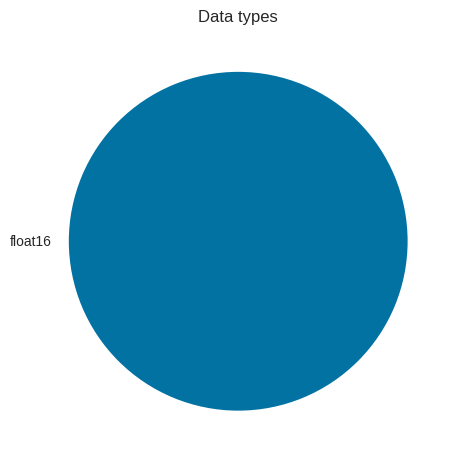

In [14]:
plot_dataframe_structure(df)

In [15]:
df = outliers(df, threshold_Z)

Using Z_score,  0  rows will be suppressed.


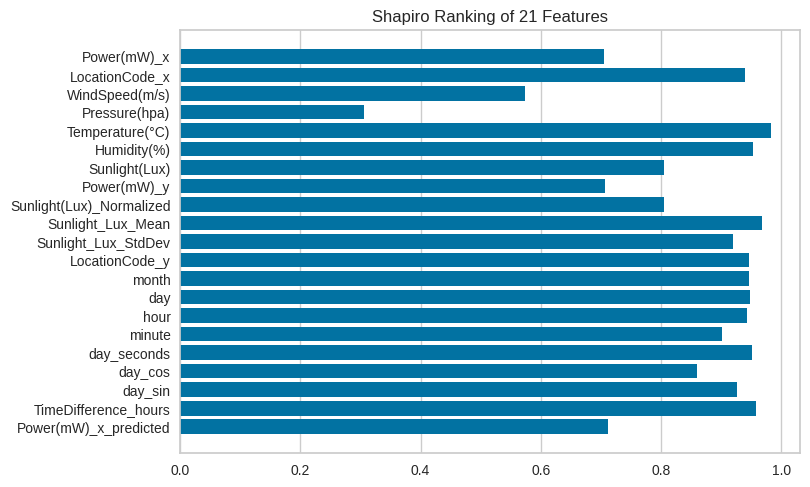

In [16]:
rank1d(df);

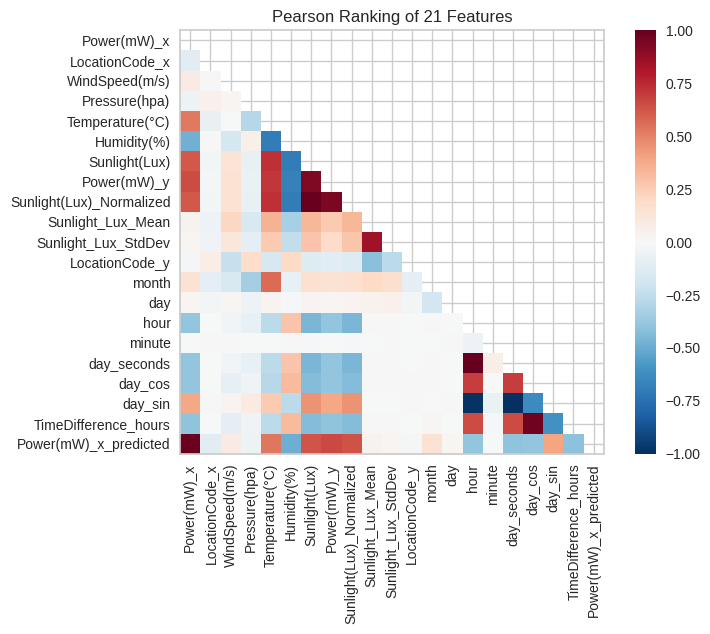

In [17]:
rank2d(df, algorithm='pearson');

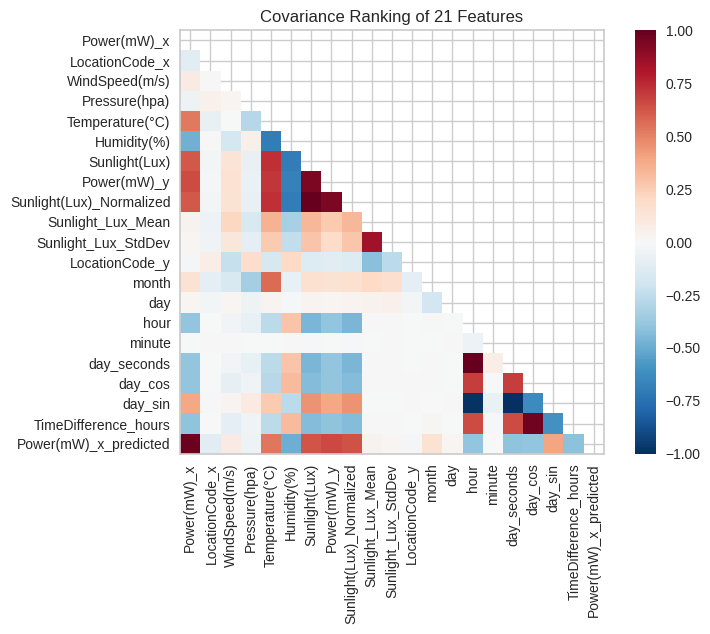

In [18]:
rank2d(df, algorithm='covariance');

In [19]:
correlated_features = correlated_columns(df, threshold_corr, target_col) 
dropped_cols = np.unique(np.concatenate((drop_cols, correlated_features)))

In [20]:
y = df[target_col]
X = df.drop(target_col, axis=1)

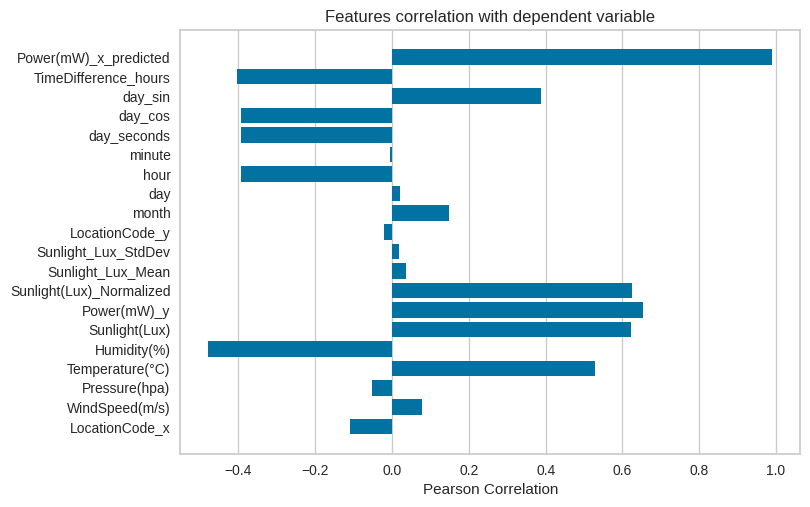

In [21]:
feature_correlation(X, y);

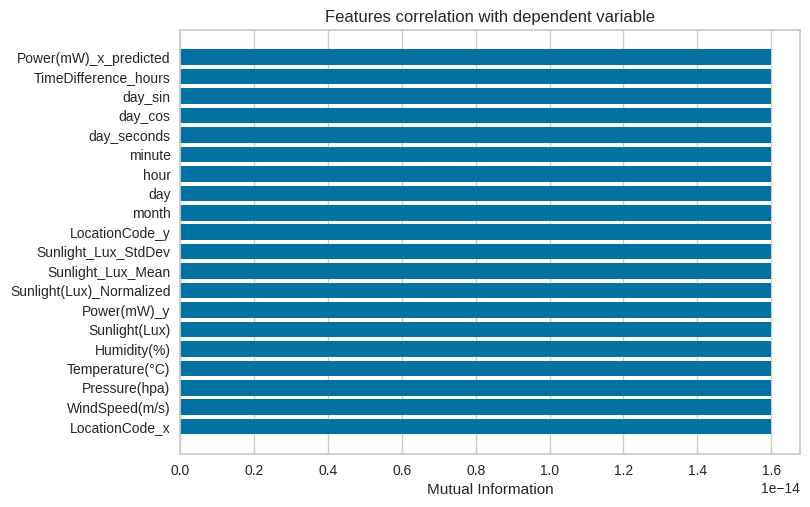

In [22]:
feature_correlation(X, y, method='mutual_info-regression');

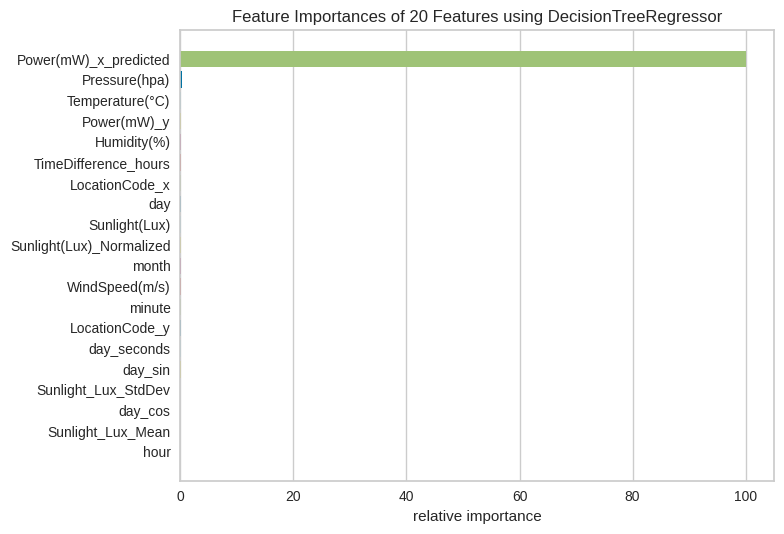

In [23]:
feature_importances(DecisionTreeRegressor(), X, y);

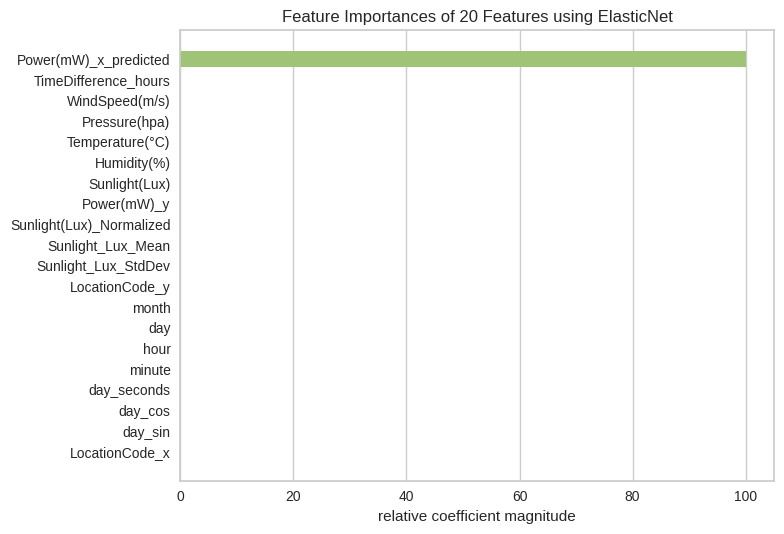

In [24]:
feature_importances(ElasticNet(alpha=0.01, l1_ratio=0.5), X, y);

In [25]:
df = df_copy
y = df[target_col]
X = df.drop(target_col, axis=1)
nb_features = len(X.columns.tolist())
nb_targets = 1
layer_size = nb_features + nb_targets + 2

In [26]:
random_state = 42

In [27]:
X_train, X_test, y_train, y_test = split(X, y, test_size=test_size, threshold_entropy=threshold_entropy, undersampling= undersampling, undersampler= undersampler, random_state = random_state)

In [28]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_tree_processor = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
num_tree_processor = make_pipeline(IterativeImputer(random_state=0, add_indicator=True))
tree_preprocessor = make_pipeline(make_column_transformer((num_tree_processor, num_selector), (cat_tree_processor, cat_selector)), Decorrelator(threshold_corr))
cat_ntree_processor = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', sparse_output=False))
num_ntree_processor = make_pipeline(IterativeImputer(random_state=0, add_indicator=True), StandardScaler())
ntree_preprocessor = make_pipeline(make_column_transformer((num_ntree_processor, num_selector), (cat_ntree_processor, cat_selector)), Decorrelator(threshold_corr))

In [29]:
from lightgbm import LGBMRegressor
level_0 = [ 
          #('GPRL', make_pipeline(ntree_preprocessor, GaussianProcessRegressor(kernel = ConstantKernel() * DotProduct() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          #('GPRR', make_pipeline(ntree_preprocessor, GaussianProcessRegressor(kernel = ConstantKernel() * RBF() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          #('GPRQ', make_pipeline(ntree_preprocessor, GaussianProcessRegressor(kernel = ConstantKernel() * RationalQuadratic() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          #('DTRF', make_pipeline(tree_preprocessor, DecisionTreeRegressor(criterion='friedman_mse', random_state = random_state))), 
          #('DTRA', make_pipeline(tree_preprocessor, DecisionTreeRegressor(criterion='absolute_error', random_state = random_state))), 
          #('DTRP', make_pipeline(tree_preprocessor, DecisionTreeRegressor(criterion='poisson', random_state = random_state))), 
          #('RFRS', make_pipeline(tree_preprocessor, RandomForestRegressor(criterion='squared_error', n_estimators=100, random_state = random_state))), 
          #('RFRA', make_pipeline(tree_preprocessor, RandomForestRegressor(criterion='absolute_error', n_estimators=100, random_state = random_state))), 
          #('RFRP', make_pipeline(tree_preprocessor, RandomForestRegressor(criterion='poisson', n_estimators=100, random_state = random_state))), 
          #('ABR', make_pipeline(tree_preprocessor, AdaBoostRegressor(random_state = random_state))), 
          ('HGBR', make_pipeline(tree_preprocessor, HistGradientBoostingRegressor(loss = 'absolute_error', early_stopping=True, random_state = random_state))), 
          #('ELNE', make_pipeline(ntree_preprocessor, ElasticNet(alpha=0.01, l1_ratio=0.15, random_state = random_state))), 
          #('ELNECV', make_pipeline(ntree_preprocessor, ElasticNetCV(cv=5, random_state = random_state))), 
          #('LINR', make_pipeline(ntree_preprocessor, LinearRegression())), 
          #('MLPR1', make_pipeline(ntree_preprocessor, MLPRegressor(hidden_layer_sizes = (layer_size, ), max_iter=2000, early_stopping=True, random_state = random_state))), 
          #('MLPR2', make_pipeline(ntree_preprocessor, MLPRegressor(hidden_layer_sizes = (layer_size, layer_size,), max_iter=2000, early_stopping=True, random_state = random_state))), 
          #('KNRU', make_pipeline(ntree_preprocessor, KNeighborsRegressor(weights='uniform'))), 
          #('KNRD', make_pipeline(ntree_preprocessor, KNeighborsRegressor(weights='distance'))), 
          #('SVR', make_pipeline(ntree_preprocessor, SVR())),  # Support Vector Regression
          #('XGBR', make_pipeline(tree_preprocessor, xgb)),  # XGBoost Regressor
          #('LGBMR', make_pipeline(tree_preprocessor, lgb.LGBMRegressor(objective='regression_l1', random_state=random_state))),
          #('CatBoostR', make_pipeline(tree_preprocessor, CatBoostRegressor(verbose=0, random_state=random_state))),  # CatBoost Regressor
          #('BayesianRidge', make_pipeline(ntree_preprocessor, BayesianRidge())),  # Bayesian Ridge Regression
          #('Lasso', make_pipeline(ntree_preprocessor, Lasso(alpha=0.01, random_state=random_state))),  # Lasso Regression
           ('LGBM', make_pipeline(tree_preprocessor, LGBMRegressor(objective='regression', n_estimators=15000, learning_rate=0.15, random_state=random_state, n_jobs=-1, force_row_wise=True ))),
           ('LGBMx', make_pipeline(tree_preprocessor, LGBMRegressor(objective='mae',n_estimators= 15000,learning_rate=0.15,random_state=random_state,n_jobs=-1,force_row_wise=True)))

]


In [30]:
level_1 =  LGBMRegressor(objective='mae', n_estimators=10000, learning_rate=0.1, random_state=random_state, n_jobs = -1, force_row_wise=True,extra_trees=True,)

In [31]:
model = StackingRegressor(level_0, final_estimator=level_1, n_jobs=-1)

In [32]:
%%time 
set_config(display='diagram') 
model.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 1686
[LightGBM] [Info] Number of data points in the train set: 400534, number of used features: 14
[LightGBM] [Info] Start training from score 367.988733
[LightGBM] [Info] Total Bins 1686
[LightGBM] [Info] Number of data points in the train set: 400535, number of used features: 14
[LightGBM] [Info] Start training from score 55.130001
[LightGBM] [Info] Total Bins 1686
[LightGBM] [Info] Number of data points in the train set: 400534, number of used features: 14
[LightGBM] [Info] Start training from score 55.470001
[LightGBM] [Info] Total Bins 1686
[LightGBM] [Info] Number of data points in the train set: 400534, number of used features: 14
[LightGBM] [Info] Start training from score 366.858145
[LightGBM] [Info] Total Bins 1686
[LightGBM] [Info] Number of data points in the train set: 400534, number of used features: 14
[LightGBM] [Info] Start training from score 55.070999
[LightGBM] [Info] Total Bins 1686
[LightGBM] [Info] Number of data points in the train s

StackingRegressor(estimators=[('HGBR',
                               Pipeline(steps=[('pipeline',
                                                Pipeline(steps=[('columntransformer',
                                                                 ColumnTransformer(transformers=[('pipeline-1',
                                                                                                  Pipeline(steps=[('iterativeimputer',
                                                                                                                   IterativeImputer(add_indicator=True,
                                                                                                                                    random_state=0))]),
                                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d8944fa3ed0>),
                                                                                                 ('pipeline-2',
                                                                                                  Pipeline(steps...
                                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d8944fa27d0>)])),
                                                                ('decorrelator',
                                                                 Decorrelator(threshold=0.75))])),
                                               ('lgbmregressor',
                                                LGBMRegressor(force_row_wise=True,
                                                              learning_rate=0.15,
                                                              n_estimators=15000,
                                                              n_jobs=-1,
                                                              objective='mae',
                                                              random_state=42))]))],
                  final_estimator=LGBMRegressor(extra_trees=True,
                                                force_row_wise=True,
                                                n_estimators=10000, n_jobs=-1,
                                                objective='mae',
                                                random_state=42),
                  n_jobs=-1)

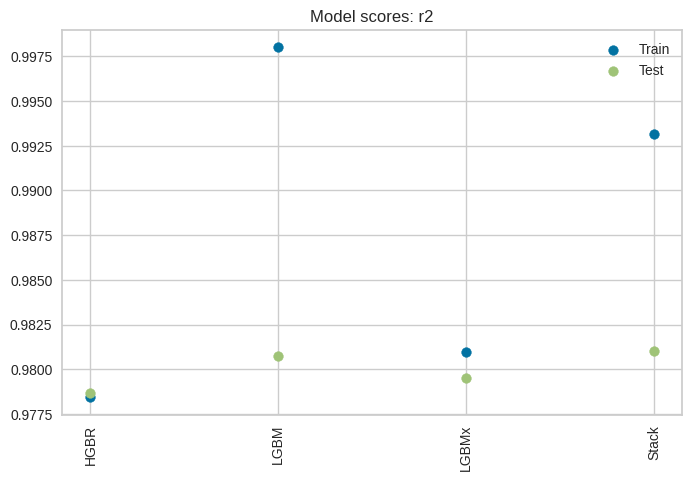

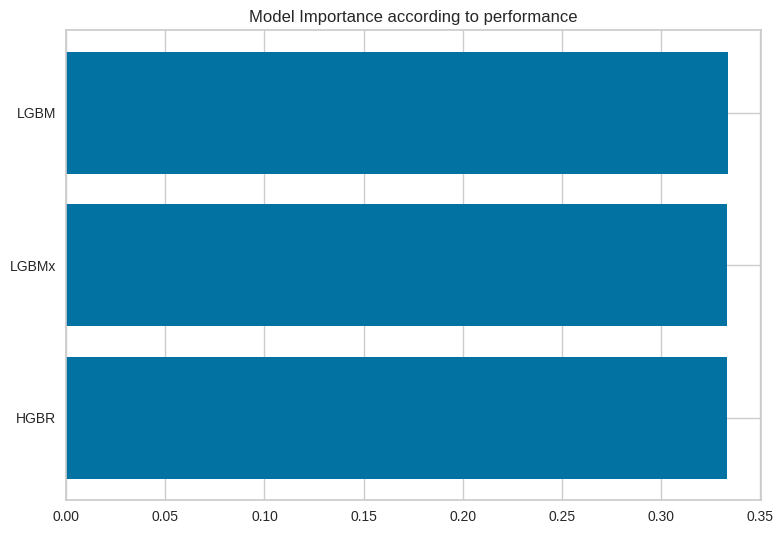

In [33]:
score_stack_0, mod_imp_score_0 = score_stacking(model, X_train, y_train, X_test, y_test)

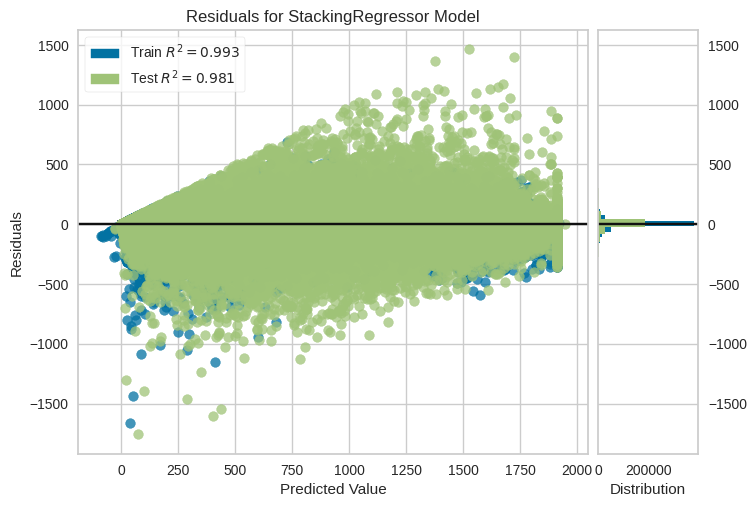

In [41]:
residuals_plot(model, X_train, y_train, X_test, y_test);

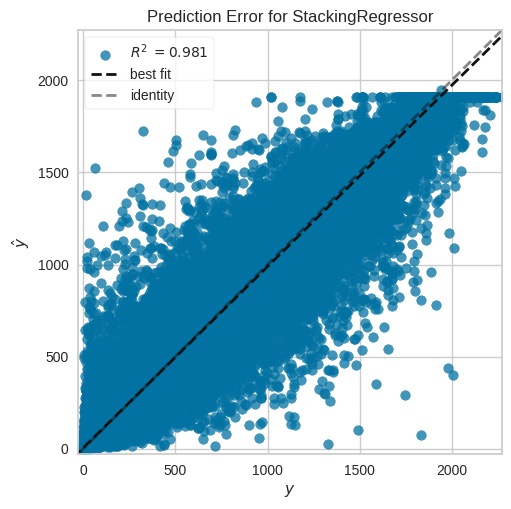

In [35]:
prediction_error(model, X_train, y_train, X_test, y_test);

In [36]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, model.predict(X_test))

30.45101472618382

In [37]:
upload = pd.read_csv('upload_24.csv')
#upload2 = pd.read_csv('upload_unfit_two_LocationCode.csv')
upload.rename(columns={"Power(mW)": "Power(mW)_y"}, inplace=True)
#upload2.rename(columns={"Power(mW)": "Power(mW)_y"}, inplace=True)

#upload = pd.concat([upload1, upload2], ignore_index=True)


In [38]:
upload = feature_engineering(upload)
longitude = 121.56387313547269
upload['Date'] = pd.to_datetime(upload['DateTime']).dt.date

# Create a dictionary to store solar noon for each unique day
solar_noon_dict_precise = {}

for date in upload['Date'].unique():
    # Calculate days since 2000 for this date
    query_date = datetime.combine(date, datetime.min.time())
    days_since_2000 = epoch_2k_day(query_date)
    eot = equation_of_time(days_since_2000)
    offset = longitude_offset(eot, longitude)
    solar_noon_time = solar_noon_precise(offset, timezone_offset=8)  # Adjust for UTC+8
    solar_noon_dict_precise[date] = solar_noon_time

# Map the solar noon time back to the DataFrame
upload['SolarNoon'] = upload['Date'].map(solar_noon_dict_precise)

# Convert SolarNoon to datetime object for comparison
upload['SolarNoon'] = pd.to_datetime(upload['Date'].astype(str) + ' ' + upload['SolarNoon'], format='%Y-%m-%d %H:%M:%S')

# Convert DateTime to actual datetime format
upload['DateTime'] = pd.to_datetime(upload['DateTime'])

# Calculate the time difference between DateTime and SolarNoon
upload['TimeDifference'] = (upload['DateTime'] - upload['SolarNoon']).abs()
upload['TimeDifference_hours'] = upload['TimeDifference'].dt.total_seconds() / 3600
# Display the updated DataFrame with time difference
upload[['DateTime', 'SolarNoon', 'TimeDifference_hours']].head()
upload.drop(columns=['TimeDifference', 'SolarNoon','Date'], inplace=True)

In [39]:

upload['答案'] = model.predict(upload)
upload['答案'] = upload['答案'].apply(lambda x: max(x, 0))

submit = upload.groupby('序號', as_index=False)['答案'].mean()
submit

,序號,答案
0,20240106090001,586.296570
1,20240106091001,1084.072729
2,20240106092001,1255.270492
3,20240106093001,1442.329434
4,20240106094001,1484.258612
...,...,...
9401,20241018163008,0.351768
9402,20241018164004,5.237651
9403,20241018164008,0.235498
9404,20241018165004,1.924750


In [40]:
#submit.to_csv('submit_24_0412_4.csv' , index = False)